# Случайный лес

# Классификация

Первые 5 строк и размер датасета

In [50]:
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit

In [51]:
# df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
#                                   "tan5577/heart-failure-dataset/versions/1",
#                                   "heart.csv")
df = pd.read_csv("heart.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Обработка категориальных и числовых признаков

In [3]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_features = ['Sex', 'FastingBP', 'ExerciseAngina']
categorical_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())

Функция для матрицы ошибок.

In [4]:
def conf_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

Создание препроцессора

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

Запуск модели от sklearn на обычном бейзлайне без улучшений.

Бейзлайн GradientBoostingClassifier:
Accuracy: 0.8750
ROC-AUC:  0.9285
F1-score: 0.8867
Recall:   0.8824


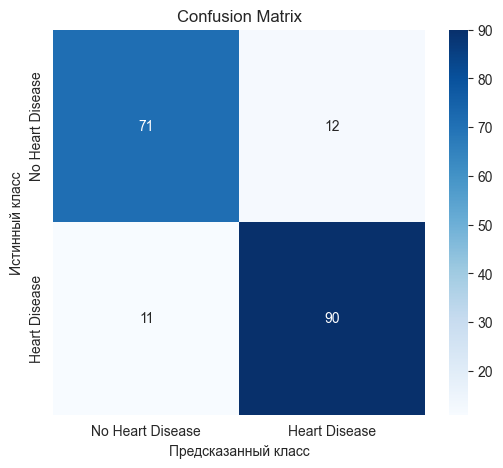

In [9]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=21))
])

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Бейзлайн GradientBoostingClassifier:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_test, y_pred)

Подберем оптимальные параметры. \
n_estimators — сколько деревьев построить. Чем больше — тем мощнее модель, но после определённого момента начинается переобучение или просто тратится время впустую. \
learning_rate (темп обучения) — насколько сильно каждое новое дерево «исправляет» ошибки предыдущих. \
Маленький темп (например, 0.01) — модель учится медленно, но стабильно. \
Большой (0.2 и выше) — быстрее, но может «проскочить» оптимум. \
Обычно выбирают небольшой learning_rate и компенсируют его большим n_estimators. \
max_depth — глубина каждого дерева. В бустинге деревья обычно очень простые (глубина 1–5). Такие «слабые ученики» лучше обобщаются, и их ансамбль даёт высокое качество. \
min_samples_split и min_samples_leaf — так же, как и в других деревьях, защищают от переобучения на мелких группах: не позволяют делить узлы, в которых слишком мало пациентов. \
subsample — доля обучающих данных, которую случайно берут для построения каждого дерева (аналог бутстрапа в случайном лесе). \
Например, 0.7 означает, что каждое дерево видит только 70% данных. Это добавляет случайности и уменьшает переобучение (техника называется стохастический градиентный бустинг). \
max_features — сколько признаков (возраст, холестерин и т.д.) использовать при поиске лучшего разделения в каждом узле. Как и в случайном лесе, это добавляет разнообразие между деревьями и улучшает обобщение.

In [20]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 300],
    'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [1, 2, 3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0],
    'classifier__max_features': ['sqrt', 'log2', None]
}

rand_search = RandomizedSearchCV(
    gb,
    param_grid,
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=21
)

rand_search.fit(X_train, y_train)

print("Лучшие параметры:", rand_search.best_params_)
print("Лучший ROC-AUC:", rand_search.best_score_)

best_params = rand_search.best_params_

Лучшие параметры: {'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05}
Лучший ROC-AUC: 0.9260461750434651


Запустим на тестовых данных

Улучшенный GradientBoostingClassifier:
Accuracy: 0.8913
ROC-AUC:  0.9387
F1-score: 0.9020
Recall:   0.9020


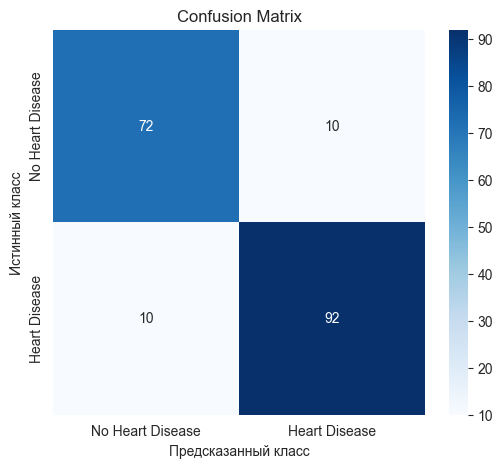

In [21]:
best_gb = rand_search.best_estimator_
best_gb.fit(X_train, y_train)
y_pred = best_gb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_gb.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Улучшенный GradientBoostingClassifier:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_pred, y_test)

### Ручная реализация

In [22]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Форма обработанных данных:", X_train_processed.shape)

Форма обработанных данных: (734, 15)


In [26]:
import numpy as np

def _sse_from_sums(sum_y, sum_y2, n):
    sse = sum_y2 - (sum_y * sum_y) / np.maximum(n, 1)
    sse = np.where(n > 0, sse, 0.0)
    return sse

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None,
                 random_state=None):
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.random_state = np.random.RandomState(random_state)
        self.tree_ = None

    def _choose_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                m = max(1, int(np.sqrt(n_features)))
            elif self.max_features == 'log2':
                m = max(1, int(np.log2(n_features)))
            else:
                raise ValueError("max_features string must be 'sqrt' or 'log2' or None")
        elif isinstance(self.max_features, float):
            if not (0.0 < self.max_features <= 1.0):
                raise ValueError("max_features float must be in (0, 1]")
            m = max(1, int(self.max_features * n_features))
        else:
            m = int(self.max_features)
            m = max(1, min(m, n_features))
        return self.random_state.choice(n_features, m, replace=False)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        n_samples, n_features = X.shape

        self.n_features_in_ = n_features

        idx_all = np.arange(n_samples)
        root_container = {}
        stack = [(idx_all, 0, root_container, 'root')]

        while stack:
            idx, depth, container, key = stack.pop()
            n_node = idx.size
            node = {}

            if (n_node < self.min_samples_split or
                (self.max_depth is not None and depth >= self.max_depth) or
                n_node <= self.min_samples_leaf or
                np.unique(y[idx]).size == 1):
                node['is_leaf'] = True
                node['value'] = float(np.mean(y[idx]) if n_node > 0 else 0.0)
                container[key] = node
                continue

            feat_idx = self._choose_feature_indices(n_features)

            y_node = y[idx]
            sum_y = y_node.sum()
            sum_y2 = (y_node * y_node).sum()

            best_sse = np.inf
            best_feat = None
            best_thresh = None
            best_left_idx = None
            best_right_idx = None

            for f in feat_idx:
                Xf = X[idx, f]
                order = np.argsort(Xf, kind='quicksort')
                Xf_sorted = Xf[order]
                y_sorted = y_node[order]

                y_cumsum = np.cumsum(y_sorted)
                y2_cumsum = np.cumsum(y_sorted * y_sorted)
                total_sum = y_cumsum[-1]
                total_sum2 = y2_cumsum[-1]

                left_counts = np.arange(1, n_node + 1)
                valid_left = (left_counts >= self.min_samples_leaf) & (left_counts <= n_node - self.min_samples_leaf)
                if not np.any(valid_left):
                    continue

                diff_mask = np.empty(n_node - 1, dtype=bool)
                diff_mask[:] = (Xf_sorted[:-1] != Xf_sorted[1:])
                candidates = np.nonzero(diff_mask)[0]
                if candidates.size == 0:
                    continue

                candidates = candidates[(candidates + 1 >= self.min_samples_leaf) & (n_node - (candidates + 1) >= self.min_samples_leaf)]
                if candidates.size == 0:
                    continue

                left_n = (candidates + 1).astype(np.int64)
                left_sum = y_cumsum[candidates]
                left_sum2 = y2_cumsum[candidates]
                right_n = n_node - left_n
                right_sum = total_sum - left_sum
                right_sum2 = total_sum2 - left_sum2

                sse_left = _sse_from_sums(left_sum, left_sum2, left_n)
                sse_right = _sse_from_sums(right_sum, right_sum2, right_n)
                sse_total = sse_left + sse_right

                idx_min = np.argmin(sse_total)
                sse_min = float(sse_total[idx_min])

                if sse_min < best_sse:
                    best_sse = sse_min
                    pos = candidates[idx_min]
                    thr = (float(Xf_sorted[pos]) + float(Xf_sorted[pos + 1])) / 2.0
                    best_feat = int(f)
                    best_thresh = thr
                    left_mask_sorted = np.zeros(n_node, dtype=bool)
                    left_mask_sorted[:pos + 1] = True
                    left_idx = idx[order[left_mask_sorted]]
                    right_idx = idx[order[~left_mask_sorted]]
                    best_left_idx = left_idx
                    best_right_idx = right_idx

            if best_feat is None:
                node['is_leaf'] = True
                node['value'] = float(np.mean(y[idx]) if n_node > 0 else 0.0)
                container[key] = node
                continue

            node['is_leaf'] = False
            node['feature'] = best_feat
            node['threshold'] = best_thresh
            node['value'] = float(np.mean(y[idx]))
            node['left'] = None
            node['right'] = None
            container[key] = node

            stack.append((best_right_idx, depth + 1, node, 'right'))
            stack.append((best_left_idx, depth + 1, node, 'left'))

        self.tree_ = root_container['root']
        return self

    def _predict_one(self, x, node):
        while not node['is_leaf']:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def predict(self, X):
        X = np.asarray(X)
        preds = np.empty(X.shape[0], dtype=float)
        for i, x in enumerate(X):
            preds[i] = self._predict_one(x, self.tree_)
        return preds



class MyGradientBoostingClassifier:
    def __init__(
        self,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=1.0,
        max_features=None,
        random_state=None
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.F0 = None


    def _predict_proba_raw(self, X):
        F = np.full(X.shape[0], self.F0)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return expit(F)

    def predict_proba(self, X):
        p = self._predict_proba_raw(X)
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        p = self._predict_proba_raw(X)
        return (p >= 0.5).astype(int)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples = len(X)
        rng = np.random.default_rng(self.random_state)

        pos = np.clip(y.mean(), 1e-5, 1 - 1e-5)
        self.F0 = np.log(pos / (1 - pos))

        for m in range(self.n_estimators):
            if self.subsample < 1.0:
                idx = rng.choice(n_samples, int(n_samples * self.subsample), replace=False)
                X_sub = X[idx]
                y_sub = y[idx]
            else:
                X_sub = X
                y_sub = y

            p = expit(self._predict_proba_raw(X_sub))
            r = y_sub - p

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            )
            tree.fit(X_sub, r)

            self.trees.append(tree)

        return self



Запустим без улучшений и с улучшением.

Ручная реализация GradientBoostingClassifier:
Accuracy: 0.7717
ROC-AUC:  0.8586
F1-score: 0.7835
Recall:   0.7451


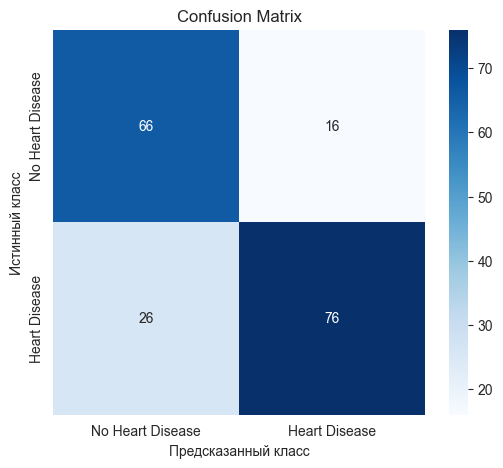


Улучшенная ручная GradientBoostingClassifier:
Accuracy: 0.8587
ROC-AUC:  0.9210
F1-score: 0.8713
Recall:   0.8627


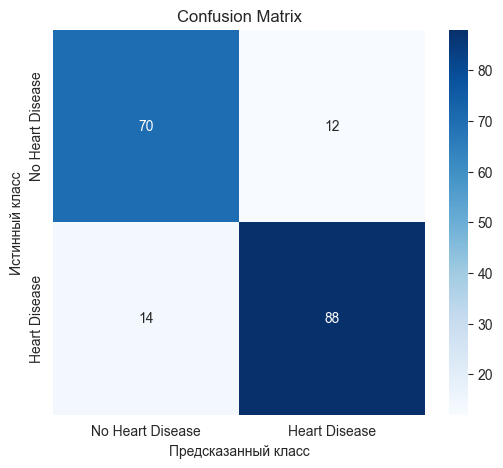

In [27]:
gb_my = MyGradientBoostingClassifier(random_state=21)
gb_my.fit(X_train_processed, y_train)

y_pred_my = gb_my.predict(X_test_processed)
y_proba_my = gb_my.predict_proba(X_test_processed)[:, 1]

acc_my = accuracy_score(y_test, y_pred_my)
roc_auc_my = roc_auc_score(y_test, y_proba_my)
f1_my = f1_score(y_test, y_pred_my)
recall_my = recall_score(y_test, y_pred_my)

print("Ручная реализация GradientBoostingClassifier:")
print(f"Accuracy: {acc_my:.4f}")
print(f"ROC-AUC:  {roc_auc_my:.4f}")
print(f"F1-score: {f1_my:.4f}")
print(f"Recall:   {recall_my:.4f}")

conf_matrix(y_pred_my, y_test)


gb_my_best = MyGradientBoostingClassifier(
    n_estimators=best_params['classifier__n_estimators'],
    max_depth=best_params['classifier__max_depth'],
    min_samples_split=best_params['classifier__min_samples_split'],
    min_samples_leaf=best_params['classifier__min_samples_leaf'],
    max_features=best_params['classifier__max_features'],
    learning_rate=best_params['classifier__learning_rate'],
    subsample=best_params['classifier__subsample'],
    random_state=21
)
gb_my_best.fit(X_train_processed, y_train)

y_pred_best = gb_my_best.predict(X_test_processed)
y_proba_best = gb_my_best.predict_proba(X_test_processed)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
f1_best = f1_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)

print(f"\nУлучшенная ручная GradientBoostingClassifier:")
print(f"Accuracy: {acc_best:.4f}")
print(f"ROC-AUC:  {roc_auc_best:.4f}")
print(f"F1-score: {f1_best:.4f}")
print(f"Recall:   {recall_best:.4f}")

conf_matrix(y_pred_best, y_test)

# Регрессия

In [28]:
# df_reg = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
#                                   "kundanbedmutha/exam-score-prediction-dataset",
#                                   "Exam_Score_Prediction.csv")

df_reg = pd.read_csv("Exam_Score_Prediction.csv")

df_reg.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


Обработка категориальных признаков

In [29]:
df_reg['internet_access'] = df_reg['internet_access'].map({'yes': 1, 'no': 0})

sleep_map = {'poor': 0, 'average': 1, 'good': 2}
exam_diff_map = {'easy': 0, 'moderate': 1, 'hard': 2}
facil_diff_map = {'low': 0, 'medium': 1, 'high': 2}

df_reg['sleep_quality'] = df_reg['sleep_quality'].map(sleep_map)
df_reg['exam_difficulty'] = df_reg['exam_difficulty'].map(exam_diff_map)
df_reg['facility_rating'] = df_reg['facility_rating'].map(facil_diff_map)

print("NaN после маппинга:")
print(df_reg[['sleep_quality', 'exam_difficulty', 'facility_rating']].isnull().sum())

NaN после маппинга:
sleep_quality      0
exam_difficulty    0
facility_rating    0
dtype: int64


Как и в прошлой работе визуализируем целевую переменную

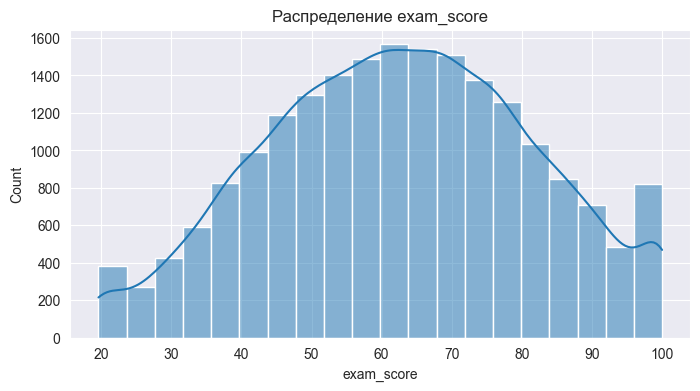

Статистика exam_score:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64


In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(df_reg['exam_score'], kde=True, bins=20)
plt.title('Распределение exam_score')
plt.show()

print("Статистика exam_score:")
print(df_reg['exam_score'].describe())

Модель от sklearn

In [31]:
X = df_reg.drop('exam_score', axis=1)
y = df_reg['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
binary_features = ['internet_access']
ordinal_features = ['sleep_quality', 'exam_difficulty', 'facility_rating']
categorical_features = ['gender', 'course', 'study_method']

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', 'passthrough', ordinal_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

gb_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', GradientBoostingRegressor(random_state=21))
])

gb_reg.fit(X_train, y_train)
y_pred_baseline = gb_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae = mean_absolute_error(y_test, y_pred_baseline)
r2 = r2_score(y_test, y_pred_baseline)

print(f"Бейзлайн GradientBoostingRegressor:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.6f}")

Бейзлайн GradientBoostingRegressor:
RMSE: 9.906500
MAE:  7.989449
R²:   0.725637


Подберем гиперпараметры. \
Параметр loss определяет, как именно модель измеряет ошибку при обучениию. \
squared_error — штрафует большие ошибки очень сильно. \
absolute_error — штрафует ошибки пропорционально их размеру. Менее чувствителен к выбросам, но оптимизировать сложнее. \
huber — гибрид двух предыдущих: ведёт себя как squared_error для небольших ошибок (плавно), но как absolute_error для крупных (устойчив к выбросам). Часто даёт лучший баланс между точностью и надёжностью.

In [40]:
param_grid = {
    'regressor__n_estimators': [50, 100, 150, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [2, 3, 4, 5],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 4, 8],
    'regressor__subsample': [0.5, 0.7, 0.9, 1.0],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__loss': ['squared_error', 'absolute_error', 'huber']
}

grid_reg = RandomizedSearchCV(
    gb_reg,
    param_distributions=param_grid,
    n_iter=40,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=21
)

grid_reg.fit(X_train, y_train)

print("Лучшие параметры:", grid_reg.best_params_)
print("Лучший RMSE:", -grid_reg.best_score_)

Лучшие параметры: {'regressor__subsample': 0.9, 'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__max_features': None, 'regressor__max_depth': 2, 'regressor__loss': 'squared_error', 'regressor__learning_rate': 0.05}
Лучший RMSE: 9.944221646214


In [41]:
best_model = grid_reg.best_estimator_
best_params = grid_reg.best_params_
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nУлучшенная модель GradientBoostingRegressor:")
print(f"RMSE: {rmse_best:.6f}")
print(f"MAE:  {mae_best:.6f}")
print(f"R²:   {r2_best:.6f}")


Улучшенная модель GradientBoostingRegressor:
RMSE: 9.907883
MAE:  8.001427
R²:   0.725561


### Ручная реализация

In [42]:
import numpy as np


def _sse_from_sums(sum_y, sum_y2, n):
    sse = sum_y2 - (sum_y * sum_y) / np.maximum(n, 1)
    sse = np.where(n > 0, sse, 0.0)
    return sse

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None,
                 random_state=None):
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.random_state = np.random.RandomState(random_state)
        self.tree_ = None

    def _choose_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                m = max(1, int(np.sqrt(n_features)))
            elif self.max_features == 'log2':
                m = max(1, int(np.log2(n_features)))
            else:
                raise ValueError("max_features string must be 'sqrt' or 'log2' or None")
        elif isinstance(self.max_features, float):
            if not (0.0 < self.max_features <= 1.0):
                raise ValueError("max_features float must be in (0, 1]")
            m = max(1, int(self.max_features * n_features))
        else:
            m = int(self.max_features)
            m = max(1, min(m, n_features))
        return self.random_state.choice(n_features, m, replace=False)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        n_samples, n_features = X.shape

        self.n_features_in_ = n_features

        idx_all = np.arange(n_samples)
        root_container = {}
        stack = [(idx_all, 0, root_container, 'root')]

        while stack:
            idx, depth, container, key = stack.pop()
            n_node = idx.size
            node = {}

            if (n_node < self.min_samples_split or
                (self.max_depth is not None and depth >= self.max_depth) or
                n_node <= self.min_samples_leaf or
                np.unique(y[idx]).size == 1):
                node['is_leaf'] = True
                node['value'] = float(np.mean(y[idx]) if n_node > 0 else 0.0)
                container[key] = node
                continue

            feat_idx = self._choose_feature_indices(n_features)

            y_node = y[idx]
            sum_y = y_node.sum()
            sum_y2 = (y_node * y_node).sum()

            best_sse = np.inf
            best_feat = None
            best_thresh = None
            best_left_idx = None
            best_right_idx = None

            for f in feat_idx:
                Xf = X[idx, f]
                order = np.argsort(Xf, kind='quicksort')
                Xf_sorted = Xf[order]
                y_sorted = y_node[order]

                y_cumsum = np.cumsum(y_sorted)
                y2_cumsum = np.cumsum(y_sorted * y_sorted)
                total_sum = y_cumsum[-1]
                total_sum2 = y2_cumsum[-1]

                left_counts = np.arange(1, n_node + 1)
                valid_left = (left_counts >= self.min_samples_leaf) & (left_counts <= n_node - self.min_samples_leaf)
                if not np.any(valid_left):
                    continue

                diff_mask = np.empty(n_node - 1, dtype=bool)
                diff_mask[:] = (Xf_sorted[:-1] != Xf_sorted[1:])
                candidates = np.nonzero(diff_mask)[0]
                if candidates.size == 0:
                    continue

                candidates = candidates[(candidates + 1 >= self.min_samples_leaf) & (n_node - (candidates + 1) >= self.min_samples_leaf)]
                if candidates.size == 0:
                    continue

                left_n = (candidates + 1).astype(np.int64)
                left_sum = y_cumsum[candidates]
                left_sum2 = y2_cumsum[candidates]
                right_n = n_node - left_n
                right_sum = total_sum - left_sum
                right_sum2 = total_sum2 - left_sum2

                sse_left = _sse_from_sums(left_sum, left_sum2, left_n)
                sse_right = _sse_from_sums(right_sum, right_sum2, right_n)
                sse_total = sse_left + sse_right

                idx_min = np.argmin(sse_total)
                sse_min = float(sse_total[idx_min])

                if sse_min < best_sse:
                    best_sse = sse_min
                    pos = candidates[idx_min]
                    thr = (float(Xf_sorted[pos]) + float(Xf_sorted[pos + 1])) / 2.0
                    best_feat = int(f)
                    best_thresh = thr
                    left_mask_sorted = np.zeros(n_node, dtype=bool)
                    left_mask_sorted[:pos + 1] = True
                    left_idx = idx[order[left_mask_sorted]]
                    right_idx = idx[order[~left_mask_sorted]]
                    best_left_idx = left_idx
                    best_right_idx = right_idx

            if best_feat is None:
                node['is_leaf'] = True
                node['value'] = float(np.mean(y[idx]) if n_node > 0 else 0.0)
                container[key] = node
                continue

            node['is_leaf'] = False
            node['feature'] = best_feat
            node['threshold'] = best_thresh
            node['value'] = float(np.mean(y[idx]))
            node['left'] = None
            node['right'] = None
            container[key] = node

            stack.append((best_right_idx, depth + 1, node, 'right'))
            stack.append((best_left_idx, depth + 1, node, 'left'))

        self.tree_ = root_container['root']
        return self

    def _predict_one(self, x, node):
        while not node['is_leaf']:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def predict(self, X):
        X = np.asarray(X)
        preds = np.empty(X.shape[0], dtype=float)
        for i, x in enumerate(X):
            preds[i] = self._predict_one(x, self.tree_)
        return preds

class MyGradientBoostingRegressor:
    def __init__(
        self,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=1.0,
        max_features=None,
        random_state=None
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.F0 = None

    def _predict_raw(self, X):
        F = np.full(X.shape[0], self.F0)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return F

    def predict(self, X):
        X = np.asarray(X)
        return self._predict_raw(X)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples = len(X)
        rng = np.random.default_rng(self.random_state)

        self.F0 = y.mean()

        F = np.full(n_samples, self.F0)

        for m in range(self.n_estimators):
            if self.subsample < 1.0:
                idx = rng.choice(n_samples, int(n_samples * self.subsample), replace=False)
                X_sub = X[idx]
                y_sub = y[idx]
                F_sub = F[idx]
            else:
                X_sub = X
                y_sub = y
                F_sub = F
            residuals = y_sub - F_sub

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            )
            tree.fit(X_sub, residuals)

            self.trees.append(tree)

            F += self.learning_rate * tree.predict(X)

        return self


In [43]:
X_train_processed = preprocessor_reg.fit_transform(X_train)
X_test_processed = preprocessor_reg.transform(X_test)

In [45]:
X_train_processed = np.asarray(X_train_processed)
y_train = np.asarray(y_train)
X_test_processed = np.asarray(X_test_processed)
y_test = np.asarray(y_test)

my_gb_reg = MyGradientBoostingRegressor(random_state=21)
my_gb_reg.fit(X_train_processed, y_train)
y_pred_my = my_gb_reg.predict(X_test_processed)

rmse_my = np.sqrt(mean_squared_error(y_test, y_pred_my))
mae_my = mean_absolute_error(y_test, y_pred_my)
r2_my = r2_score(y_test, y_pred_my)

print("Ручная GradientBoostingRegressor:")
print(f"RMSE: {rmse_my:.6f}")
print(f"MAE:  {mae_my:.6f}")
print(f"R²:   {r2_my:.6f}")


my_gb_reg_best = MyGradientBoostingRegressor(
    n_estimators=best_params['regressor__n_estimators'],
    max_depth=best_params['regressor__max_depth'],
    min_samples_split=best_params['regressor__min_samples_split'],
    min_samples_leaf=best_params['regressor__min_samples_leaf'],
    max_features=best_params['regressor__max_features'],
    learning_rate=best_params['regressor__learning_rate'],
    subsample=best_params['regressor__subsample'],
    random_state=21
)
my_gb_reg_best.fit(X_train_processed, y_train)
y_pred_tree_my = my_gb_reg_best.predict(X_test_processed)

rmse_best_my = np.sqrt(mean_squared_error(y_test, y_pred_tree_my))
mae_best_my = mean_absolute_error(y_test, y_pred_tree_my)
r2_best_my = r2_score(y_test, y_pred_tree_my)

print(f"\nУлучшенная ручная GradientBoostingRegressor:")
print(f"RMSE: {rmse_best_my:.6f}")
print(f"MAE:  {mae_best_my:.6f}")
print(f"R²:   {r2_best_my:.6f}")

Ручная GradientBoostingRegressor:
RMSE: 9.906500
MAE:  7.989449
R²:   0.725637

Улучшенная ручная GradientBoostingRegressor:
RMSE: 9.910214
MAE:  8.001253
R²:   0.725431


Как видим улучшенная ручная реализация показала примерно те же результаты, что и модель от sklearn.

# Подведение итогов

## Классификация

### Алгоритмы от sklearn с лучшими метриками

| Алгоритм                | Accuracy   | ROC-AUC    | F1-score   | Recall     |
|-------------------------|------------|------------|------------|------------|
| KNN                     | 0.8587     | 0.9334     | 0.8725     | 0.8725     |
| Логистическая регрессия | 0.8859     | 0.9305     | 0.8986     | **0.9118** |
| Решающее дерево         | 0.7935     | 0.8251     | 0.8155     | 0.8235     |
| Случайный лес           | 0.8696     | 0.9283     | 0.8812     | 0.8725     |
| Градиентный бустинг     | **0.8913** | **0.9387** | **0.9020** | 0.9020     |

### Ручная имплементация алгоритмов с лучшими метриками

| Алгоритм                | Accuracy    | ROC-AUC    | F1-score   | Recall     |
|-------------------------|-------------|------------|------------|------------|
| KNN                     | 0.8478      | 0.9258     | 0.8627     | 0.8627     |
| Логистическая регрессия | 0.8478      | 0.9235     | 0.8641     | 0.8725     |
| Решающее дерево         | 0.7989      | 0.7971     | 0.8177     | 0.8137     |
| Случайный лес           | **0.8750**  | **0.9350** | **0.8878** | **0.8922** |
| Градиентный бустинг     | 0.8587      | 0.9210     | 0.8713     | 0.8627     |

### Выводы по задаче классификации
Градиентный бустинг хорошо улавливает сложные нелинейные зависимости между медицинскими показателями, что типично для кардиологических данных. \
Логистическая регрессия работает почти так же хорошо. Линейные зависимости между признаками и вероятностью заболевания выражены достаточно сильно. Это типично в кардиологии: возраст, давление, холестерин, боль в груди — всё это часто влияет почти линейно. \
Случайный лес и KNN тоже сильные, но уступают. Потому что медицинские данные: шумные, с выбросами, с нелинейными взаимодействиями (например, влияние MaxHR зависит от возраста) \
Gradient Boosting умеет это моделировать точнее.\
Ваши ручные реализации немного уступают sklearn, и это нормально. Но ручной случайный лес показал очень высокое качество.

## Регрессия

### Алгоритмы от sklearn с лучшими метриками

| Алгоритм            | RMSE       | MAE        | R²         |
|---------------------|------------|------------|------------|
| KNN                 | 10.7870    | 8.7259     | 0.6747     |
| Линейная регрессия  | **9.7706** | **7.8623** | **0.7331** |
| Решающее дерево     | 11.4302    | 9.2350     | 0.6347     |
| Случайный лес       | 10.4484    | 8.4980     | 0.6948     |
| Градиентный бустинг | 9.9065     | 7.9894     | 0.7256     |

### Ручная имплементация алгоритмов с лучшими метриками

| Алгоритм            | RMSE       | MAE        | R²         |
|---------------------|------------|------------|------------|
| KNN                 | 10.7870    | 8.7259     | 0.6747     |
| Линейная регрессия  | **9.7706** | **7.8623** | **0.7331** |
| Решающее дерево     | 11.4163    | 9.2272     | 0.6356     |
| Случайный лес       | 10.4621    | 8.5041     | 0.6939     |
| Градиентный бустинг | 9.9065     | 7.9894     | 0.7256     |

### Выводы по задаче регрессии
Лучшая модель — LinearRegression. Зависимости в данных в основном линейные. Это объясняет, почему деревья и бустинг дают слабый прирост. \
GradientBoostingRegressor — почти на уровне лидера, всего на 1 процентный пункт хуже линейной регрессии. Деревья захватывают немного нелинейности, но она незначительна \
RandomForest и KNN — средние результаты \
Ручные реализации - почти полные аналоги sklearn